In [20]:
from corda import CORDA
from corda import reaction_confidence
from cobra.io import read_sbml_model
from cobra.test import create_test_model
from cobra.core import get_solution
from pandas import read_csv
import urllib
import matplotlib.pyplot as plt
%matplotlib inline

# 1. E. coli example

In [24]:
core = create_test_model("textbook")
dat = read_csv("https://raw.githubusercontent.com/jotech/sysbio-nb/master/dat/example_dat.csv")
conf_gen = {g.id:0 for g in core.genes}
datG = dat["b_ID"]
rank = dat["TvC_Rank"]
for i,g in enumerate(datG):
    if g in conf_gen:
        conf_gen[g] = rank[i]

conf_rea = {}
for r in core.reactions:
    gpr = r.gene_reaction_rule
    conf= {g.id:conf_gen[g.id] for g in r.genes}
    conf_rea[r.id] = reaction_confidence(gpr, conf)

In [25]:
opt = CORDA(core, conf_rea, met_prod="o2_e")
%time opt.build()

CPU times: user 59.7 ms, sys: 0 ns, total: 59.7 ms
Wall time: 59.7 ms


(array([  3.,   1.,  63.,  18.,   3.,   3.,   1.,   0.,   2.,   2.]),
 array([-3.46707692, -2.28136923, -1.09566154,  0.09004615,  1.27575385,
         2.46146154,  3.64716923,  4.83287692,  6.01858462,  7.20429231,
         8.39      ]),
 <a list of 10 Patch objects>)

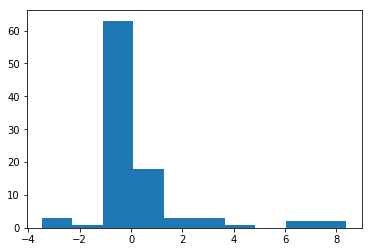

In [26]:
%matplotlib inline
sol = get_solution(opt.model)
plt.hist(sol.fluxes.values)

In [28]:
print opt
new = opt.cobra_model()

build status: reconstruction complete
Inc. reactions: 52/52
 - unclear: 42/42
 - exclude: 1/1
 - low and medium: 0/0
 - high: 9/9



In [29]:
idx = [core.reactions.index(r.id) for r in new.reactions]
flux = {r.id:sol[i] for i,r in enumerate(new.reactions)}
print {ex:round(flux[ex],2) for ex in flux if ex.startswith("EX_") and flux[ex] != 0}

{'EX_etoh_e': 0.58, 'EX_h2o_e': 0.0, 'EX_for_e': 6.93, 'EX_h_e': 0.58, 'EX_co2_e': -3.47}


# 2. Recon example

In [9]:
expr_dat = read_csv("https://raw.githubusercontent.com/jotech/sysbio-nb/master/dat/gene_state.csv")
urllib.urlretrieve("https://raw.githubusercontent.com/jotech/sysbio-nb/master/dat/recon2v04.xml", "recon2v04.xml")
mod = read_sbml_model("recon2v04.xml")

(array([ 1052.,     0.,  5381.,     0.,     0.,     0.,     0.,     0.,
            0.,  1007.]),
 array([-1. , -0.6, -0.2,  0.2,  0.6,  1. ,  1.4,  1.8,  2.2,  2.6,  3. ]),
 <a list of 10 Patch objects>)

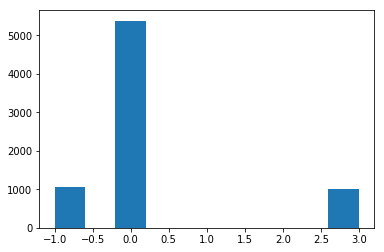

In [15]:
conf_gen = {g.id:0 for g in mod.genes}
datG = expr_dat["Unnamed: 0"]
rank = expr_dat["CD_ni_TILE"]
for i,g in enumerate(datG):
    gid = str(g)+".1"
    if gid in conf_gen:
        if rank[i] == 1:
            level = 3
        elif rank[i] == 0:
            level = -1
        conf_gen[gid] = level
        
conf_rea = {}
for r in mod.reactions:
    # corda has problems with '.' in gene ids => remove '.'
    gpr = r.gene_reaction_rule.replace(".","") 
    conf= {g.id.replace(".",""):conf_gen[g.id] for g in r.genes}
    conf_rea[r.id] = reaction_confidence(gpr, conf)
plt.hist(conf_rea.values())

In [16]:
opt = CORDA(mod, conf_rea)
%time opt.build()

CPU times: user 15min 26s, sys: 2.11 s, total: 15min 28s
Wall time: 15min 27s


(array([    0.,     0.,     0.,     0.,     0.,  7440.,     0.,     0.,
            0.,     0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <a list of 10 Patch objects>)

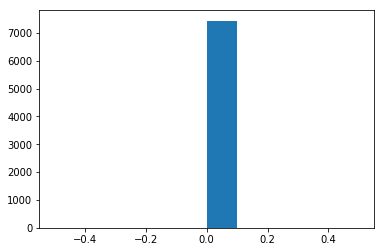

In [17]:
# get glpk solutions from corda optimization
# https://github.com/resendislab/corda/issues/7
#
corda_sol = get_solution(opt.model)
plt.hist(corda_sol.fluxes.values)

In [18]:
# statistics for model

print opt
new = opt.cobra_model()

build status: reconstruction complete
Inc. reactions: 2519/7440
 - unclear: 1541/5381
 - exclude: 159/1052
 - low and medium: 0/0
 - high: 819/1007

